In [1]:
from IPython.display import Image
from matplotlib import pyplot as plt
from scipy.stats import lognorm
import arviz
import numpy as np
import pandas as pd
import pystan
plt.style.use('sparse.mplstyle')

# Analysing a simple biochemical reaction system using Stan

Svetlana kindly sent me an example of a simple biochemical model to help my understanding. This notebook is my attempt to reproduce Svetlana's analysis using Stan.

The example concerns a simple linear system of chemical equations with the following structure:

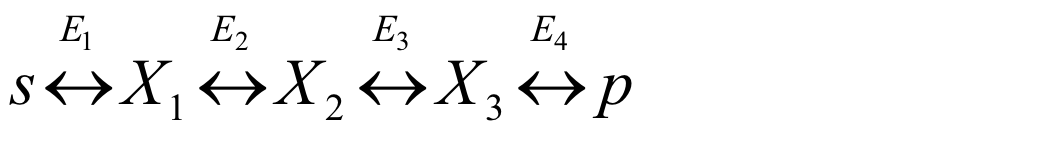

In [2]:
Image("equation.png")

In this picture $s$ and $p$ represent substrate and product concentrations, $X_1$, $X_2$ and $X_3$ represent intermediate metabolite concentrations and $E_1$, $E_2$, $E_3$ and $E_4$ represent concentrations of four different enzymes, each of which catalyses the reaction represented by its arrow.

We have a hypothetical scenario where there have been three experiments `Ex_1`, `Ex_2` and `Ex_3`. In each experiment, the system was left for a while with the concentrations of the enzymes, substrate and product being kept fixed while the concentrations of the metabolites were left to vary. Once enough time had passed to be confident that the concentrations were no longer changing, the concentrations of the metabolites were measured. In addition, we have some `Ref` values which serve to normalise our data. Here is how our results might look:

In [3]:
data = pd.read_csv('data.csv', index_col=0)
data

,E1,E2,E3,E4,s,p,X1,X2,X3,v
Ex_1,1,1,1,2,1.0,1,0.90,0.9,0.75,0.11
Ex_2,1,2,1,1,1.0,1,0.90,1.2,1.10,0.12
Ex_3,1,1,1,1,0.5,2,0.65,0.9,1.30,0.05
Ref,1,1,1,1,1.0,1,1.00,1.0,1.00,0.10


After having done the experiment, we would now like to know what we have learned about our enzymes. More specifically, suppose we know that the reactions' rates can be parameterised as follows


$$
\begin{align*}
v_1&=E_1\cdot\frac{kcat_1\cdot(S-X_1/Keq_1)}{S+Km_1+X_1/Keq_1} \\
v_2&=E_2\cdot\frac{kcat_2\cdot(X_1-X_2/Keq_2)}{X_1+Km_2+X_2/Keq_2}\cdot\frac{1}{1+X_3/KI_2} \\
v_3&=E_3\cdot\frac{kcat_3\cdot(X_2-X_3/Keq_3)}{X_2+Km_3+X_3/Keq_3} \\
v_4&=E_4\cdot\frac{kcat_4\cdot(X_3-P/Keq_4)}{X_3+Km_4+P/Keq_4} \\
\end{align*}
$$

where $kcat$, $Km$ and $Keq$ are enzyme-specific constants and $KI_2$ represents the extent to which the concentration of metabolite $X_3$ inhibits reaction 2.

Together with the graph above, these rate equations imply a system of ODEs describing how the concentrations will change over time:

$$
\begin{align*}
&\frac{dS}{dt} = -v1 \\
&\frac{dX_1}{dt} = v1-v2 \\
&\frac{dX_2}{dt} = v2-v3 \\
&\frac{dX_3}{dt} = v3-v4 \\
&\frac{dP}{dt} = v4 \\
&\end{align*}
$$

In order to learn from our experimental data, we will use the following method:

1. Come up with a plausible prior distribution for each of the system's parameters.
2. Come up with numbers describing the accuracy of the measurements
3. Combine our prior distributions with our measurement model using Bayesian inference.

The trickiest part of this approach is to say what measurements are implied by a given prior configuration. In this notebook I have addressed this problem by solving the system of equations under the assumption that the concentrations of internal metabolites are not changing, i.e. $\frac{dX_1}{dt} = \frac{dX_2}{dt} = \frac{dX_3}{dt} = 0$. This can be done using Stan's built in equation solver - the process works roughly as follows.

1. Stan's Hamiltonian Monte Carlo algorithm presents a configuration of parameter values, including .
2. We use the flux equations and the concentrations of controlled substances to express $\frac{dX_1}{dt}$, $\frac{dX_2}{dt}$ and $\frac{dX_3}{dt}$ as functions of internal metabolite concentrations $X_1,...,X_3$.
3. We use the algebra solver to find the values of $X_1$, $X_2$ and $X_3$ where $\frac{dX_1}{dt}$, $\frac{dX_2}{dt}$ and $\frac{dX_3}{dt}$ are all zero.
4. We plug the modelled values of $X_1$, $X_2$ and $X_3$ back into the flux equations to find modelled values of $v_1, ..., v_4$

See [here](https://mc-stan.org/docs/2_18/stan-users-guide/algebra-solver-chapter.html) for more about Stan's algebra solver.

First we compile a Stan model from a file and print its code

In [4]:
model = pystan.StanModel(file='reaction_model.stan')
print(model.model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_abc287bbfc78c27b6b92ebfc782ae8ad NOW.


functions {
#include big_k_equations.stan
}
data {
  // experimental data
  int<lower=1> N_metabolite;
  int<lower=1> N_controlled;
  int<lower=1> N_experiment;
  real measured_metabolite[N_experiment, N_metabolite];
  real controlled_concentration[N_experiment, N_controlled];
  real measured_flux[N_experiment];
  // hardcoded priors
  vector<lower=0>[N_metabolite] sigma_metabolite;
  real<lower=0> sigma_flux;
  vector[3] enzyme_parameter_mean;
  vector<lower=0>[3] enzyme_parameter_sd;
  real K_I_mean;
  real K_I_sd;
  // model config
  real rel_tol;
  real f_tol;
  int max_steps;
  int<lower=0,upper=1> LIKELIHOOD;
}
parameters {
  vector<lower=0>[4] k_cat;
  vector<lower=0>[4] K_eq;
  vector<lower=0>[4] K_m;
  real<lower=0> K_I;
}
transformed parameters {
  matrix[N_experiment, N_metabolite] metabolite_hat; 
  real flux_hat[N_experiment, 4]; 
  for (e in 1:N_experiment){
    vector[13] theta = append_row(append_row(append_row(k_cat, K_eq), K_m), K_I);
    int x_i[0];
    metabolite_ha

The model includes the file `big_k_equations.stan`, which contains two  functions. Here is what they look like:

In [5]:
with open("big_k_equations.stan", "r") as f:
    print(f.read())

real[] flux_equations_big_k(vector X, vector theta, real[] x_r){
  real E[4] = x_r[1:4];
  real S = x_r[5];
  real P = x_r[6];
  real k_cat[4] = to_array_1d(theta[1:4]);
  real K_eq[4] = to_array_1d(theta[5:8]);
  real K_m[4] = to_array_1d(theta[9:12]);
  real K_I = theta[13];
  real fluxes[4];

  fluxes[1] = E[1] * k_cat[1] * (S - X[1] / K_eq[1]) * inv(S + K_m[1] + X[1] / K_eq[1]);
  fluxes[2] = E[2] * k_cat[2] * (X[1] - X[2] / K_eq[2]) * inv(X[1] + K_m[2] + X[2] / K_eq[2]) * inv(1 / (1 + X[3] / K_I));
  fluxes[3] = E[3] * k_cat[3] * (X[2] - X[3] / K_eq[3]) * inv(X[2] + K_m[3] + X[3] / K_eq[3]);
  fluxes[4] = E[4] * k_cat[4] * (X[3] - P / K_eq[4]) * inv(X[3] + K_m[4] + P    / K_eq[4]);
  return fluxes;
}
vector steady_state_equations_big_k(vector y, vector theta, real[] x_r, int[] x_i){
  real flux[4] = flux_equations_big_k(y, theta, x_r);
  vector[3] roots;

  roots[1] = flux[1] - flux[2];
  roots[2] = flux[2] - flux[3];
  roots[3] = flux[3] - flux[4];
  return roots;
}



## Configure the model

Next we need to make some configuration choices. These include some hardcoded parameters that set the model's prior distributions and some numbers that configure the algebra solver.

`sigma_metabolite` and `sigma_flux` represent how accurate we think the experimental measurements (i.e. $X_1, X_2, X_3, v$) were. The lower they are, the less we expect the true values to deviate from the measured values. This is a slightly tricky idea as all potential sources of error need to be taken into account, as well as the final chemical analysis. For example, deviations in the controlled enzyme/substrate/product concentrations would also cause errors. I chose 0.05 and 0.02 more or less arbitrarily.

`enzyme_parameter_mean`, `enzyme_parameter_sd`, `K_I_mean` and `K_I_sd` should represent the available prior information about the kinetic parameters. They are locations and scales for lognormal distributions, chosen roughly based on Svetlana's example.

`rel_tol`, `f_tol` and `max_steps` are [control parameters](https://mc-stan.org/docs/2_18/stan-users-guide/algebra-control-section.html) for the algebra solver. `f_tol` is the default value, whereas `rel_tol` is lower than the default (the default is 1e-6) and `max_steps` is higher (the default is 1e3). The combined effect is to make the solver a bit more sensitive but also a bit slower than the default.

In [6]:
# how accurate were the measurements for each metabolite?
sigma_metabolite = [0.05, 0.05, 0.05]

# how accurate were the flux measurements?
sigma_flux = 0.02

# mean and sd of log priors...
# ...enzyme parameter
enzyme_parameter_mean = [0, 0, 0]
enzyme_parameter_sd = [0.5, 0.5, 0.5]
# ...inhibition parameter
K_I_mean = 0
K_I_sd = 0.5

# equation solver parameters
rel_tol = 1e-7
f_tol = 1e-6
max_steps = int(1e6)

Here is an illustration of the prior distributions for the kinetic parameters. Ideally these distributions' areas should correspond to the available information. For example, it should be pretty unlikely that any of the parameters will have a value greater than 3 or lower than 0.1.

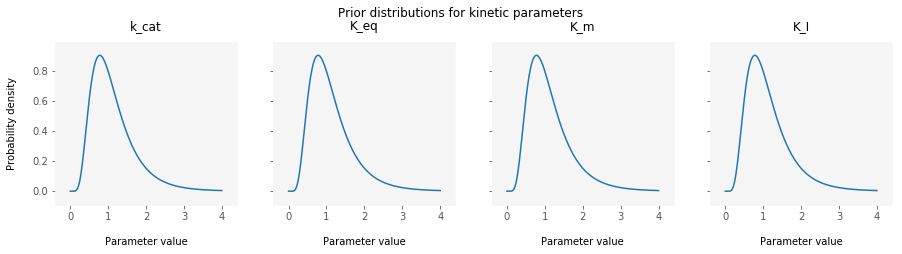

In [7]:
def plot_lognormal(ax, loc, scale, upper=4):
    xx = np.linspace(0, upper, 200)
    yy = lognorm.pdf(xx, s=scale, loc=loc)
    ax.plot(xx, yy)
    ax.set(xlabel='Parameter value')

f, axes = plt.subplots(1, 4, figsize=[15, 3], sharey=True)
    
f.suptitle('Prior distributions for kinetic parameters', y=1.04)
axes[0].set_ylabel('Probability density')
for param_name, loc, scale, ax in zip(['k_cat', 'K_eq', 'K_m', 'K_I'],
                                      [*enzyme_parameter_mean, K_I_mean],
                                      [*enzyme_parameter_sd, K_I_sd],
                                      axes):
    plot_lognormal(ax, loc, scale)
    ax.set_title(param_name, y=0.9)
    

plt.savefig('output/lognormal.png')
plt.show()

The next cell turns our configuration and experimental data into suitable input for the Stan model. Note that two data dictionaries are created, `data_prior` and `data_posterior`, which differ only in the value of the key `LIKELIHOOD`. This is so that we can run the model both with and without its measurement component.

In [8]:
experiments = ['Ref', 'Ex_1', 'Ex_2', 'Ex_3']
controlled_concentrations = ['E1', 'E2', 'E3', 'E4', 's', 'p']
enzymes = ['E1', 'E2', 'E3', 'E4']
metabolites = ['X1', 'X2', 'X3']
flux = 'v'

model_data = {
    
    # experiment results
    'N_metabolite': len(metabolites),
    'N_controlled': len(controlled_concentrations),
    'N_experiment': len(experiments),
    'measured_metabolite': data.loc[experiments, metabolites],
    'measured_flux': data.loc[experiments, flux],
    'controlled_concentration': data.loc[experiments, controlled_concentrations],
    
    # hardcoded priors
    'sigma_metabolite': sigma_metabolite,
    'sigma_flux': sigma_flux,
    'enzyme_parameter_mean': enzyme_parameter_mean,
    'enzyme_parameter_sd': enzyme_parameter_sd,
    'K_I_mean': K_I_mean,
    'K_I_sd': K_I_sd,
    
    # config
    'rel_tol': rel_tol,
    'f_tol': f_tol,
    'max_steps': max_steps
}

data_prior = {**model_data, **{'LIKELIHOOD': 0}}
data_posterior = {**model_data, **{'LIKELIHOOD': 1}}

print("data_posterior:")
display(data_posterior)

data_posterior:


{'N_metabolite': 3,
 'N_controlled': 6,
 'N_experiment': 4,
 'measured_metabolite':         X1   X2    X3
 Ref   1.00  1.0  1.00
 Ex_1  0.90  0.9  0.75
 Ex_2  0.90  1.2  1.10
 Ex_3  0.65  0.9  1.30,
 'measured_flux': Ref     0.10
 Ex_1    0.11
 Ex_2    0.12
 Ex_3    0.05
 Name: v, dtype: float64,
 'controlled_concentration':       E1  E2  E3  E4    s  p
 Ref    1   1   1   1  1.0  1
 Ex_1   1   1   1   2  1.0  1
 Ex_2   1   2   1   1  1.0  1
 Ex_3   1   1   1   1  0.5  2,
 'sigma_metabolite': [0.05, 0.05, 0.05],
 'sigma_flux': 0.02,
 'enzyme_parameter_mean': [0, 0, 0],
 'enzyme_parameter_sd': [0.5, 0.5, 0.5],
 'K_I_mean': 0,
 'K_I_sd': 0.5,
 'rel_tol': 1e-07,
 'f_tol': 1e-06,
 'max_steps': 1000000,
 'LIKELIHOOD': 1}

This cell fits the model twice (once for `data_prior` and once for `data_posterior`), then puts the output into a nice format (an arviz [`InferenceData`](https://arviz-devs.github.io/arviz/notebooks/XarrayforArviZ.html) object) and caches them.

In [9]:
fit_prior = model.sampling(data=data_prior, iter=1000, chains=4)
fit_posterior = model.sampling(data=data_posterior, iter=1000, chains=4)

infd = arviz.from_pystan(posterior=fit_posterior,
                         posterior_predictive='metabolite_pred',
                         prior_predictive='metabolite_pred',
                         observed_data='measured_metabolite',
                         prior=fit_prior,
                         coords={'experiments': experiments,
                                 'metabolites': metabolites,
                                 'enzymes': ['E1', 'E2', 'E3', 'E4']},
                         dims={'k_cat': ['enzymes'], 
                               'K_eq': ['enzymes'],
                               'K_m': ['enzymes'],
                               'measured_metabolite': ['experiments', 'metabolites'],
                               'metabolite_pred': ['experiments', 'metabolites'],
                               'metabolite_hat': ['experiments', 'metabolites']})
infd.to_netcdf('output/stan_ode_model_output.nc')

arviz.summary(infd.posterior, var_names=['k_cat', 'K_eq', 'K_m', 'K_I'])

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
k_cat[0],0.75,0.20,0.01,0.44,1.13,1143.0,1.01
k_cat[1],0.57,0.19,0.01,0.27,0.90,1127.0,1.00
k_cat[2],0.67,0.18,0.00,0.37,0.99,1458.0,1.00
k_cat[3],0.66,0.17,0.00,0.41,0.99,1421.0,1.00
K_eq[0],1.65,0.22,0.01,1.29,2.06,1476.0,1.00
K_eq[1],1.64,0.16,0.01,1.36,1.95,2142.0,1.00
K_eq[2],1.80,0.21,0.00,1.39,2.17,1687.0,1.00
K_eq[3],1.85,0.12,0.00,1.65,2.08,1824.0,1.00
K_m[0],1.14,0.55,0.02,0.32,2.19,1603.0,1.00
K_m[1],1.42,0.71,0.02,0.33,2.66,1713.0,1.00


In [10]:
def highlight_min_and_max(s):
    '''
    highlight the maximum in a Series red and the minimum blue.
    '''
    
    is_max = s == s.max()
    is_min = s == s.min()
    
    out = pd.Series('', index=s.index)
    out.loc[is_max] = 'background-color: red'
    out.loc[is_min] = 'background-color: blue'
    return out


diagnostic_df = infd.sample_stats.to_dataframe()

interesting_columns = ['treedepth', 'n_leapfrog', 'stepsize', 'energy']

max_indices = diagnostic_df[interesting_columns].idxmax()
min_indices = diagnostic_df[interesting_columns].idxmin()

(
    diagnostic_df
    .loc[pd.concat([max_indices, min_indices]), interesting_columns]
    .drop_duplicates()
    .style.apply(highlight_min_and_max)
)

A look at the fit summary, together with the lack of diagnostic warnings in the cell above, indicates that the model has probably converged successfully.

To find out what the model learned from the data, we can look at the prior and posterior distributions of the parameters. In addition, in this case we also have access to the true parameter values. The next two cells plot the prior and posterior distributions of the kinetic parameters alongside their true values.

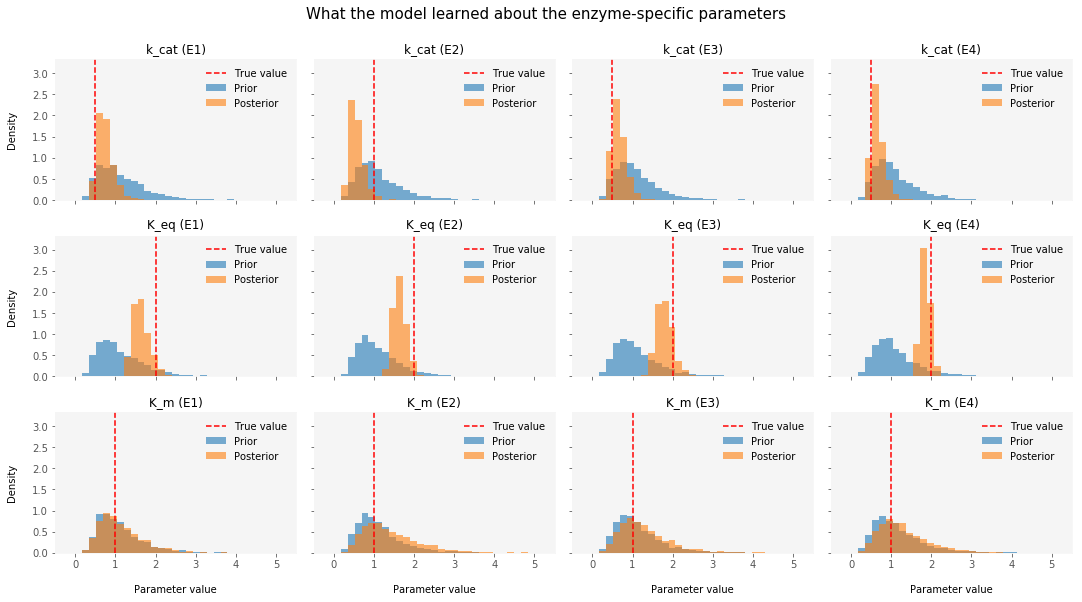

In [12]:
parameters = ['k_cat', 'K_eq', 'K_m']

true_enzyme_specific_parameter_values = pd.DataFrame({
    'k_cat': [0.5, 1, 0.5, 0.5],
    'K_eq': 2,
    'K_m': 1
}, index=['E1', 'E2', 'E3', 'E4'])

true_K_I_value = 1

bins = np.linspace(0, 5, 30)

f, axes = plt.subplots(3, 4, figsize=[15, 8], sharex=True, sharey=True)

for row, par in zip(axes, parameters):
    samples_prior = infd.prior[par].to_dataframe().unstack()[par]
    samples_posterior = infd.posterior[par].to_dataframe().unstack()[par]
    for enzyme, ax in zip(enzymes, row):
        h_prior = ax.hist(samples_prior[enzyme], alpha=0.6, bins=bins, density=True, label='Prior')
        h_posterior = ax.hist(samples_posterior[enzyme], alpha=0.6, bins=bins, density=True, label='Posterior')
        true_value_line = ax.axvline(true_enzyme_specific_parameter_values.loc[enzyme, par], 
                                     color='r', label='True value', linestyle='--')
        if ax == row[0]:
            ax.set_ylabel('Density')
        if ax in axes[-1]:
            ax.set_xlabel('Parameter value')
        ax.set_title(f'{par} ({enzyme})', y=0.85)
        leg = ax.legend(frameon=False)

f.suptitle("What the model learned about the enzyme-specific parameters", fontsize=15, y=1.04)
plt.tight_layout()
plt.savefig('output/enzyme_parameter_histograms.png')

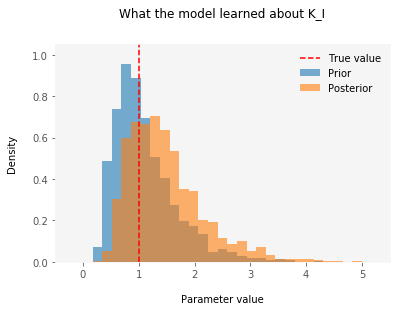

In [13]:
bins = np.linspace(0, 5, 30)
par = 'K_I'
samples_prior = infd.prior[par].to_dataframe()[par]
samples_posterior = infd.posterior[par].to_dataframe()[par]

f, ax = plt.subplots()
h_prior = ax.hist(samples_prior, alpha=0.6, bins=bins, density=True, label='Prior')
h_posterior = ax.hist(samples_posterior, alpha=0.6, bins=bins, density=True, label='Posterior')
true_value_line = ax.axvline(true_K_I_value, color='r', label='True value', linestyle='--')
leg = ax.legend(frameon=False)
text = ax.set(title='What the model learned about K_I',
              xlabel='Parameter value',
              ylabel='Density')

plt.savefig('output/K_I_histogram.png')

The model got fairly close to the true values, though it seems to not quite have got the $K_{eq}$ parameters quite right. Possibly this is because the prior distributions for these parameters give very low density to the true value. Alternatively, it could be that the model and data don't identify all the parameters fully.

Finally, the next cell does a basic prior and posterior predictive checks, comparing the observed experimental results with those expected by the model's prior and posterior distributions.

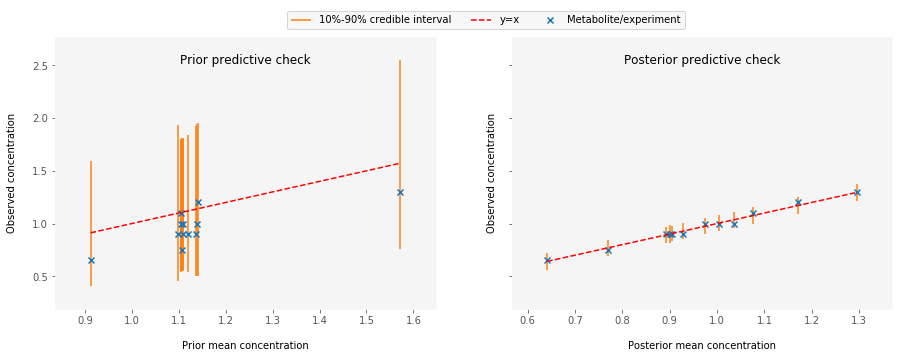

In [14]:
obs = infd.observed_data.to_dataframe()
posterior_pred = infd.posterior_predictive['metabolite_pred'].to_dataframe()
prior_pred = infd.prior_predictive['metabolite_pred'].to_dataframe()

g_posterior = posterior_pred.groupby(['experiments', 'metabolites'])
g_prior =  prior_pred.groupby(['experiments', 'metabolites'])

f, axes = plt.subplots(1, 2, figsize=[15, 5], sharey=True)

for ax, g, name in zip(axes, [g_prior, g_posterior], ['prior', 'posterior']):
    lower = g['metabolite_pred'].quantile(0.1).rename('lower')
    mean = g['metabolite_pred'].mean().rename('mean')
    upper = g['metabolite_pred'].quantile(0.9).rename('upper')
    
    xx = np.linspace(mean.min(), mean.max(), 10)
    scatter = ax.scatter(mean.reindex(obs.index), obs, marker='x')
    vlines = ax.vlines(mean, lower, upper, color='tab:orange', zorder=0, label='10%-90% credible interval')
    y_equals_x_line = ax.plot(xx, xx, color='r', linestyle='--', label='y=x')
    text = ax.set(xlabel=f'{name.capitalize()} mean concentration',
                  ylabel='Observed concentration')
    title = ax.set_title(f'{name.capitalize()} predictive check', y=0.8)

plt.figlegend([vlines, y_equals_x_line[0], scatter], 
              ['10%-90% credible interval', 'y=x', 'Metabolite/experiment'],
              ncol=3, loc='lower center', bbox_to_anchor=[0.45, 0.9])
plt.savefig('output/checks.png')

This is quite a nice result. The model learned a lot from the data, as shown by the much smaller credible intervals in the the right hand graph. In addition, in both graphs the credible intervals cover the observed values, with no particular pattern in the discrepancies. This suggests that, even though the model didn't manage to pick out all the correct parameter values, it has still done a pretty good job of extracting the information contained in the experimental data. In order to fully identify $K_{eq}$ and $K_{m}$, we could try doing new experiments or making the model's prior distributions more realistic. An easy first step would be to update the priors for `K_eq` to give more density to the true values - presumably it would have been known in advance that a value of 2 was at least plausible. More ambitiously, it might also be worth allowing the kinetic parameters' distributions to be correlated, and to include information about which correlations are more or less likely. See [here](https://github.com/markusheinonen/bamfa) for an example of this kind of approach.